## Dependencias

In [10]:
!pip install pytube

     |████████████████████████████████| 56 kB 950 kB/s eta 0:00:01
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [11]:
import os
import cv2 
import numpy as np
from pytube import YouTube
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta as rd

In [12]:
ini =datetime.now()

## Descargar video y convertir a frames

### Descargar de youtube 

In [22]:
nombre = 'SPIDER-MAN NO WAY HOME - Official Teaser Trailer (HD).mp4'

In [14]:
!rm -rf video/
!rm -rf frames/
!rm -rf detecciones/
os.system(f'rm {nombre}')
os.mkdir('detecciones')
os.mkdir('frames')

In [20]:
url = "https://www.youtube.com/watch?v=rt-2cxAiPJk"
YouTube(url).streams.get_highest_resolution().download('video')

'/tf/cloudsync/大学/repos/m4g7_cdd/practicas/video/SPIDER-MAN NO WAY HOME - Official Teaser Trailer (HD).mp4'

### Convertir a frames

In [23]:
cap = cv2.VideoCapture(os.path.join('video',os.listdir('video')[0]))
i=0
while(cap.isOpened()):
    ret, frame = cap.read()
    if ret == False:
        break
    cv2.imwrite(os.path.join('frames','frame_%05d.jpg'%i),frame)
    i+=1
cap.release()
cv2.destroyAllWindows()

## Leer frames

In [24]:
frames = sorted([os.path.join('frames',x) for x in os.listdir('frames/')])

In [25]:
imagenes= list(map(lambda im:cv2.imread(im),frames))

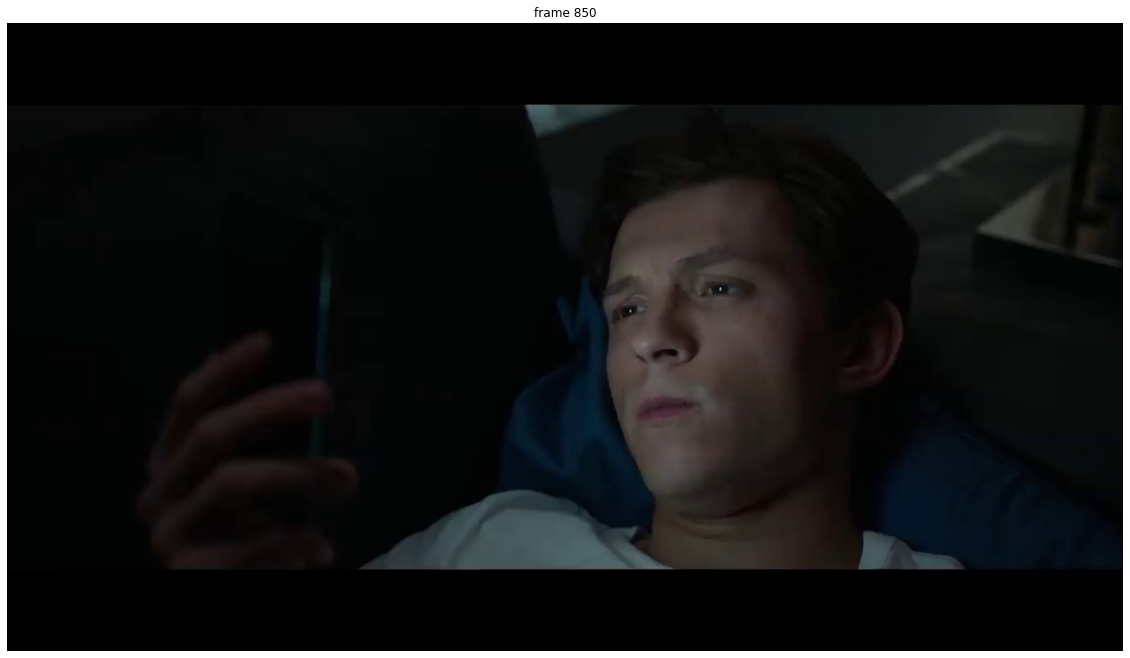

In [36]:
i = 850
plt.figure(figsize=(20,15))
plt.title(f'frame {i}')
plt.axis(False)
plt.imshow(cv2.cvtColor(imagenes[i], cv2.COLOR_BGR2RGB))

## Cargar CNN entrenada (YoloV3 sobre COCO)

In [29]:
fuente = cv2.FONT_HERSHEY_PLAIN

In [30]:
red = cv2.dnn.readNet("yolov3.weights","yolov3.cfg")
with open("coco.names","r") as f:
    clases = [line.strip() for line in f.readlines()]

## Funciones para uso de la red

In [32]:
def propagar_red(frame,red):
    capas_red = red.getLayerNames()
    capas_salida = [capas_red[i[0] - 1] for i in red.getUnconnectedOutLayers()]
    blob = cv2.dnn.blobFromImage(frame,
                                 0.00392,
                                 (416,416),
                                 (0,0,0),
                                 True,
                                 crop=False) 
    red.setInput(blob)
    salidas = red.forward(capas_salida)
    return salidas

In [33]:
def agregar_cajas_deteccion(salidas,frame):
    alto,ancho,canales = frame.shape
    colores= np.random.uniform(0,255,size=(len(clases),3))
    ids=[]
    probas=[]
    cajas=[]
    for salida in salidas:
        for deteccion in salida:
            scores = deteccion[5:]
            id_ = np.argmax(scores)
            proba = scores[id_]
            if proba > 0.8:
                centro_x= int(deteccion[0]*ancho)
                centro_y= int(deteccion[1]*alto)
                
                w = int(deteccion[2]*ancho)
                h = int(deteccion[3]*alto)
                x=int(centro_x - w/2)
                y=int(centro_y - h/2)
                cajas.append([x,y,w,h]) 
                probas.append(float(proba))
                ids.append(id_)
    indices = cv2.dnn.NMSBoxes(cajas,probas,0.4,0.6)
    
    for i in range(len(cajas)):
        if i in indices:
            x,y,w,h = cajas[i]
            etiq = str(clases[ids[i]])
            proba= probas[i]
            color = colores[ids[i]]
            cv2.rectangle(frame,(x,y),(x+w,y+h),color,2)
            cv2.putText(frame,
                        etiq+" "+str(round(proba,2)),
                        (x,y+30),
                        fuente,
                        1,
                        (255,255,255),
                        2)
    return frame

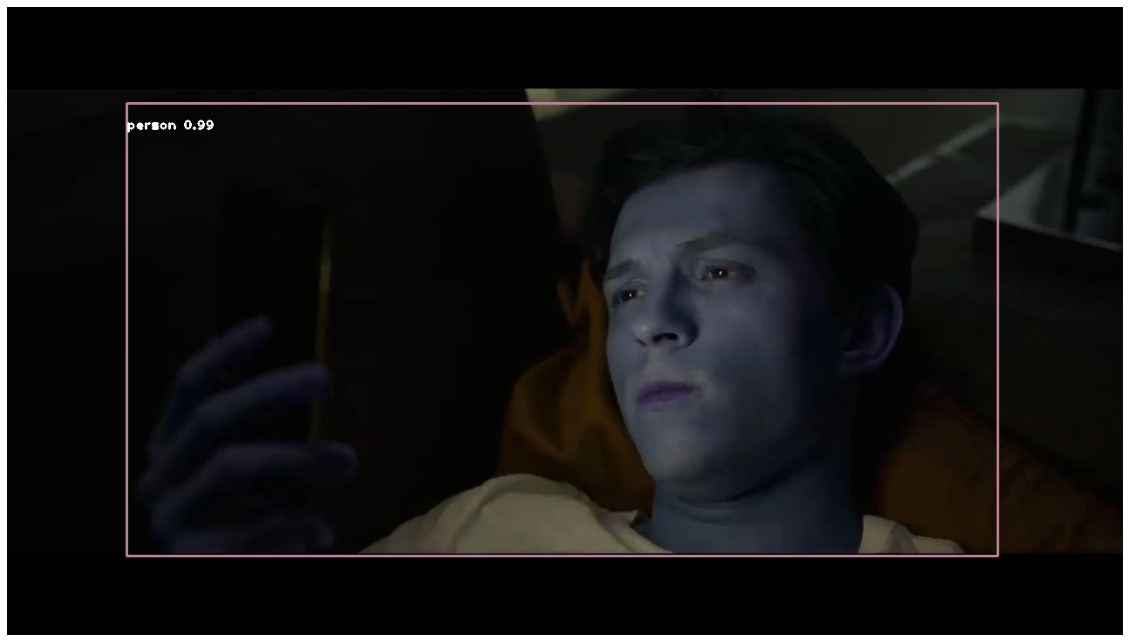

In [37]:
i = 850
frame = imagenes[i]
plt.figure(figsize=(20,15))
plt.axis(False)
plt.imshow(agregar_cajas_deteccion(propagar_red(frame,red),frame))

## Generar todas las detecciones de la red

In [38]:
for i,frame in enumerate(imagenes):
    cv2.imwrite('detecciones/%05d.png'%i,
                agregar_cajas_deteccion(propagar_red(frame,red),frame))

KeyboardInterrupt: 

## Conversión de imágenes con detecciones a video

In [39]:
fps = 24

In [40]:
imagenes = sorted([os.path.join('detecciones',
                                x) for x in os.listdir('detecciones/')])

In [41]:
frames = []
for i,archivo in enumerate(imagenes):
    img = cv2.imread(archivo)
    alto, ancho,capas = img.shape
    tam = (ancho,alto)
    frames.append(img)
    
out = cv2.VideoWriter(nombre,
                      cv2.VideoWriter_fourcc(*'DIVX'),
                      fps,
                      tam)
for frame in frames:
    out.write(frame)

out.release()

In [42]:
rd(datetime.now(),ini)

relativedelta(minutes=+22, microseconds=+978807)